In [3]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')


In [ ]:
# Cell 2: Load datasets
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')
credit_df = pd.read_csv('../data/creditcard.csv')

print("Fraud data shape:", fraud_df.shape)
print("IP to Country data shape:", ip_df.shape)
print("Credit card data shape:", credit_df.shape)


Fraud data shape: (151112, 11)
IP to Country data shape: (138846, 3)
Credit card data shape: (284807, 31)


In [5]:
# Cell 3: Handle missing values in fraud_df
print("Missing values in Fraud_Data.csv:\n", fraud_df.isnull().sum())

# For simplicity, drop rows with missing values
fraud_df = fraud_df.dropna()
print("After dropping missing values, shape:", fraud_df.shape)


Missing values in Fraud_Data.csv:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
After dropping missing values, shape: (151112, 11)


In [6]:
# Cell 4: Remove duplicates in fraud_df
print("Duplicates before:", fraud_df.duplicated().sum())
fraud_df = fraud_df.drop_duplicates()
print("Duplicates after:", fraud_df.duplicated().sum())


Duplicates before: 0
Duplicates after: 0


In [7]:
# Cell 5: Correct data types
# Convert signup_time and purchase_time to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Check datatypes
print(fraud_df.dtypes)


user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


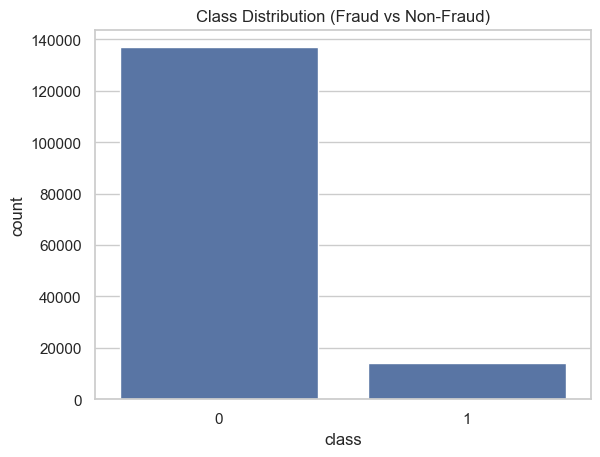

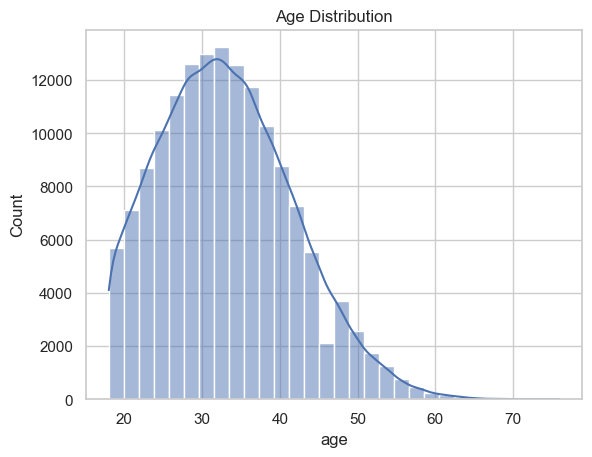

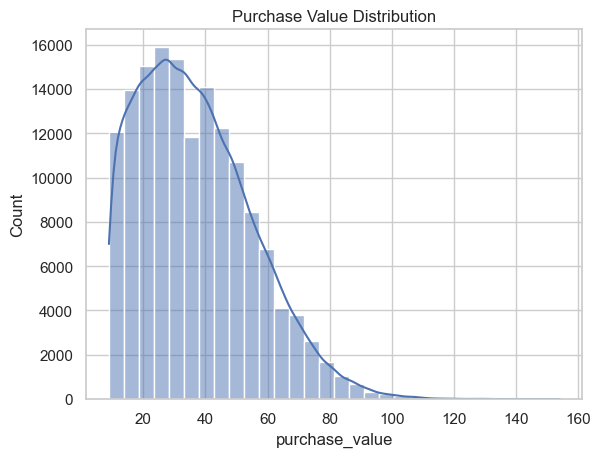

In [8]:
# Cell 6: Univariate analysis on Fraud_Data

# Class distribution
sns.countplot(x='class', data=fraud_df)
plt.title('Class Distribution (Fraud vs Non-Fraud)')
plt.show()

# Age distribution
sns.histplot(fraud_df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Purchase value distribution
sns.histplot(fraud_df['purchase_value'], bins=30, kde=True)
plt.title('Purchase Value Distribution')
plt.show()


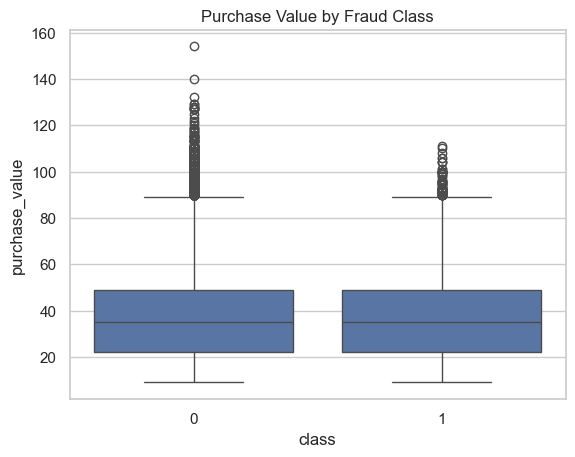

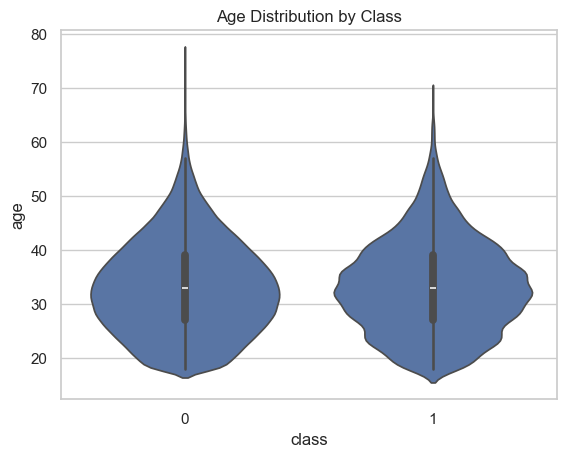

In [9]:
# Cell 7: Bivariate analysis

# Boxplot purchase_value by class
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value by Fraud Class')
plt.show()

# Age vs Class violin plot
sns.violinplot(x='class', y='age', data=fraud_df)
plt.title('Age Distribution by Class')
plt.show()


In [19]:
# Cell 8: Convert ip_address column safely to integer IPs

# First, check ip_address values
print("Sample ip_address values in fraud_df:")
print(fraud_df['ip_address'].head(10))

# Coerce to numeric, forcing errors to NaN
fraud_df['ip_address_numeric'] = pd.to_numeric(fraud_df['ip_address'], errors='coerce')

# Check for NaNs after coercion
num_nans = fraud_df['ip_address_numeric'].isna().sum()
print(f"Number of NaNs after coercion: {num_nans}")

# Drop rows with NaN IPs (if any)
fraud_df = fraud_df.dropna(subset=['ip_address_numeric'])

# Now convert to int safely
fraud_df['ip_int'] = fraud_df['ip_address_numeric'].astype(int)

# For ip_df: Convert float IP ranges directly to integers (no ip_to_int needed)
ip_df['lower_bound_ip_int'] = ip_df['lower_bound_ip_address'].astype('Int64')
ip_df['upper_bound_ip_int'] = ip_df['upper_bound_ip_address'].astype('Int64')

# Display first few rows to verify
print("Sample fraud_df with IP integer conversion:")
print(fraud_df[['ip_address', 'ip_address_numeric', 'ip_int']].head())

print("Sample ip_df with IP range integer conversion:")
print(ip_df[['lower_bound_ip_address', 'lower_bound_ip_int', 'upper_bound_ip_address', 'upper_bound_ip_int']].head())


Sample ip_address values in fraud_df:
116708    8.802175e+08
15108     2.785906e+09
46047     3.560567e+08
67650     7.591047e+08
109067    2.985180e+09
1979      5.783125e+08
111743    3.647502e+09
138000    4.253406e+09
149540    1.202326e+09
87224     3.142341e+09
Name: ip_address, dtype: float64
Number of NaNs after coercion: 0
Sample fraud_df with IP integer conversion:
          ip_address  ip_address_numeric      ip_int
116708  8.802175e+08        8.802175e+08   880217484
15108   2.785906e+09        2.785906e+09  2785906106
46047   3.560567e+08        3.560567e+08   356056736
67650   7.591047e+08        7.591047e+08   759104706
109067  2.985180e+09        2.985180e+09  2985180352
Sample ip_df with IP range integer conversion:
   lower_bound_ip_address  lower_bound_ip_int  upper_bound_ip_address  \
0              16777216.0            16777216                16777471   
1              16777472.0            16777472                16777727   
2              16777728.0            1

In [20]:
# Cell 9: Merge fraud_df with ip_df on IP range

def find_country(ip_int, ip_ranges):
    match = ip_ranges[(ip_ranges['lower_bound_ip_int'] <= ip_int) & (ip_ranges['upper_bound_ip_int'] >= ip_int)]
    if len(match) > 0:
        return match.iloc[0]['country']
    else:
        return 'Unknown'

# Apply country lookup
fraud_df['country'] = fraud_df['ip_int'].apply(lambda x: find_country(x, ip_df))

print(fraud_df[['ip_address', 'ip_int', 'country']].head())


          ip_address      ip_int        country
116708  8.802175e+08   880217484  United States
15108   2.785906e+09  2785906106    Switzerland
46047   3.560567e+08   356056736  United States
67650   7.591047e+08   759104706        Unknown
109067  2.985180e+09  2985180352         Mexico


In [21]:
# Cell 10: Feature engineering - time features

# hour_of_day from purchase_time
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour

# day_of_week from purchase_time
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek  # Monday=0

# time_since_signup in seconds
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

fraud_df[['signup_time', 'purchase_time', 'hour_of_day', 'day_of_week', 'time_since_signup']].head()


,signup_time,purchase_time,hour_of_day,day_of_week,time_since_signup
116708,2015-01-11 03:47:13,2015-02-21 10:03:37,10,5,3564984.0
15108,2015-06-02 16:40:57,2015-09-26 21:32:16,21,5,10039879.0
46047,2015-05-28 07:53:06,2015-08-13 11:53:07,11,3,6667201.0
67650,2015-05-16 15:58:32,2015-05-20 23:06:42,23,2,371290.0
109067,2015-01-10 06:25:12,2015-03-04 20:56:37,20,2,4631485.0


In [25]:
# Cell 11: Transaction frequency and velocity features (corrected)

# Ensure purchase_time is a column (not index)
if 'purchase_time' not in fraud_df.columns:
    fraud_df = fraud_df.reset_index()

# Sort by user_id and purchase_time
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time']).copy()

# Calculate time difference between transactions per user
fraud_df['prev_purchase_time'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
fraud_df['time_since_prev_purchase'] = (fraud_df['purchase_time'] - fraud_df['prev_purchase_time']).dt.total_seconds()

# Function to calculate rolling count of transactions in last 24 hours per user
def rolling_count_24h(group):
    group = group.set_index('purchase_time')
    count = group['user_id'].rolling('24h', closed='both').count()
    return count.reset_index(drop=True)

# Apply rolling count per user
fraud_df['transaction_count_24h'] = fraud_df.groupby('user_id').apply(rolling_count_24h).reset_index(level=0, drop=True)

# Display sample results
fraud_df[['user_id', 'purchase_time', 'time_since_prev_purchase', 'transaction_count_24h']].head(10)


C:\Users\HP\AppData\Local\Temp\ipykernel_13896\2422132514.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fraud_df['transaction_count_24h'] = fraud_df.groupby('user_id').apply(rolling_count_24h).reset_index(level=0, drop=True)


,user_id,purchase_time,time_since_prev_purchase,transaction_count_24h
0,2,2015-02-21 10:03:37,NaN,1.0
1,4,2015-09-26 21:32:16,NaN,1.0
2,8,2015-08-13 11:53:07,NaN,1.0
3,9,2015-05-20 23:06:42,NaN,1.0
4,12,2015-03-04 20:56:37,NaN,1.0
5,16,2015-03-12 12:46:23,NaN,1.0
6,18,2015-10-23 00:18:57,NaN,1.0
7,26,2015-03-21 09:04:08,NaN,1.0
8,33,2015-10-28 18:12:41,NaN,1.0
9,39,2015-01-08 18:13:26,NaN,1.0


class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


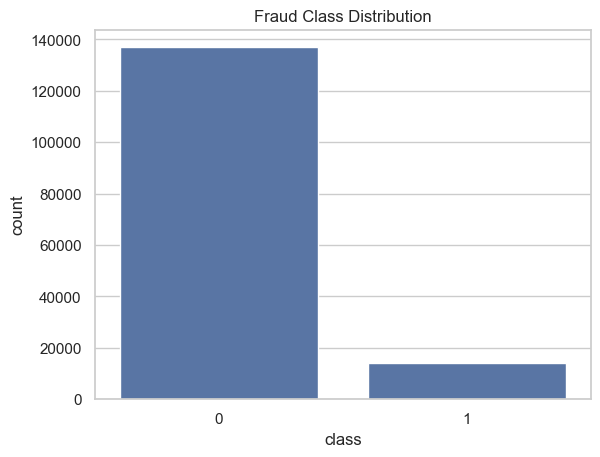

In [26]:
# Cell 12: Analyze class imbalance

print(fraud_df['class'].value_counts(normalize=True))

# Visualize imbalance
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud Class Distribution')
plt.show()


In [28]:
# Cell 13: Prepare data for modeling (feature selection & encoding)

# Select features and target
features = ['purchase_value', 'sex', 'age', 'source', 'browser', 'country', 
            'hour_of_day', 'day_of_week', 'time_since_signup', 
            'time_since_prev_purchase', 'transaction_count_24h']

target = 'class'

# Create a copy of the selected features to avoid SettingWithCopyWarning
X = fraud_df[features].copy()
y = fraud_df[target].copy()

# Handle missing values created by feature engineering (e.g. time_since_prev_purchase NaN for first txn)
X.loc[:, 'time_since_prev_purchase'] = X['time_since_prev_purchase'].fillna(-1)

# One-Hot Encode categorical variables
categorical_cols = ['sex', 'source', 'browser', 'country']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Features shape after encoding:", X_encoded.shape)


Features shape after encoding: (151112, 195)


In [29]:
# Cell 14: Normalize numeric features

numeric_cols = ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 
                'time_since_signup', 'time_since_prev_purchase', 'transaction_count_24h']

scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

X_encoded.head()


,purchase_value,age,hour_of_day,day_of_week,time_since_signup,time_since_prev_purchase,transaction_count_24h,sex_M,source_Direct,source_SEO,...,country_Unknown,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,0.931338,-0.944649,-0.220124,0.991020,-0.437279,0.0,0.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.221836,0.563874,1.371208,0.991020,1.633857,0.0,0.0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0.549298,-0.944649,-0.075457,-0.005891,0.555032,0.0,0.0,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1.367955,-1.408809,1.660541,-0.504347,-1.458852,0.0,0.0,True,False,True,...,True,False,False,False,False,False,False,False,False,False
4,-0.105627,-1.640890,1.226541,-0.504347,-0.096136,0.0,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# Cell 15: Handle class imbalance with SMOTE (only on train set)

# Split train/test before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print("Before SMOTE, training class distribution:")
print(y_train.value_counts())

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE, training class distribution:")
print(y_train_smote.value_counts())


Before SMOTE, training class distribution:
class
0    109568
1     11321
Name: count, dtype: int64
After SMOTE, training class distribution:
class
0    109568
1    109568
Name: count, dtype: int64


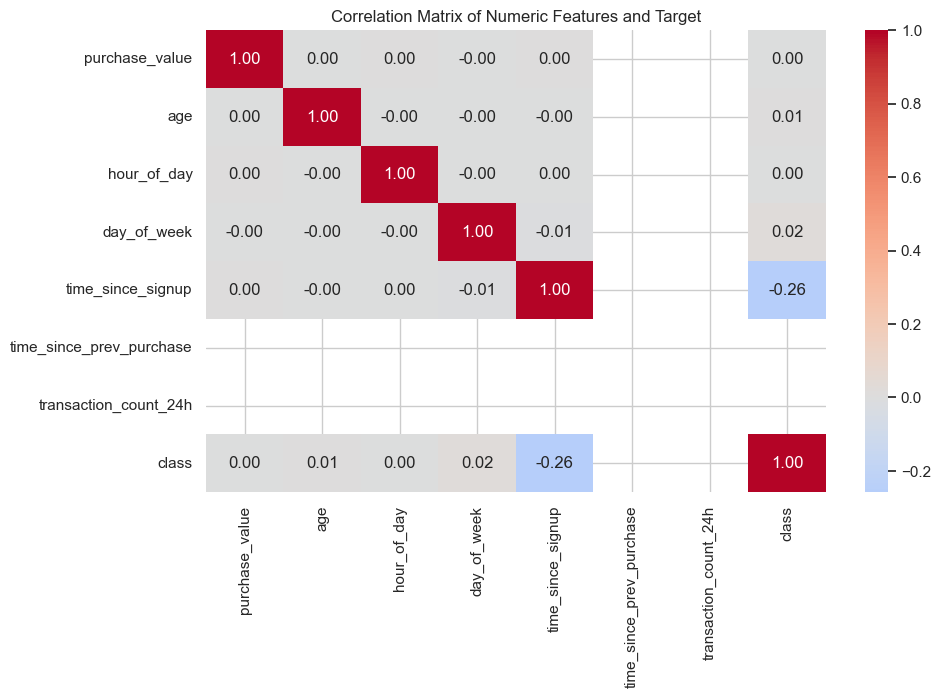

In [31]:
# Cell 16: Correlation heatmap for numeric features
numeric_features = ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 
                    'time_since_signup', 'time_since_prev_purchase', 'transaction_count_24h']

plt.figure(figsize=(10, 6))
corr = fraud_df[numeric_features + ['class']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features and Target')
plt.show()


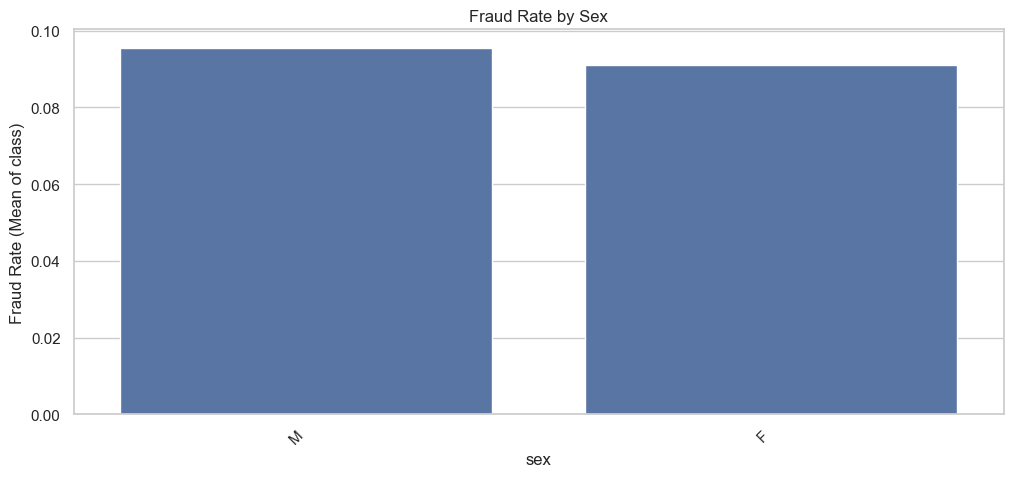

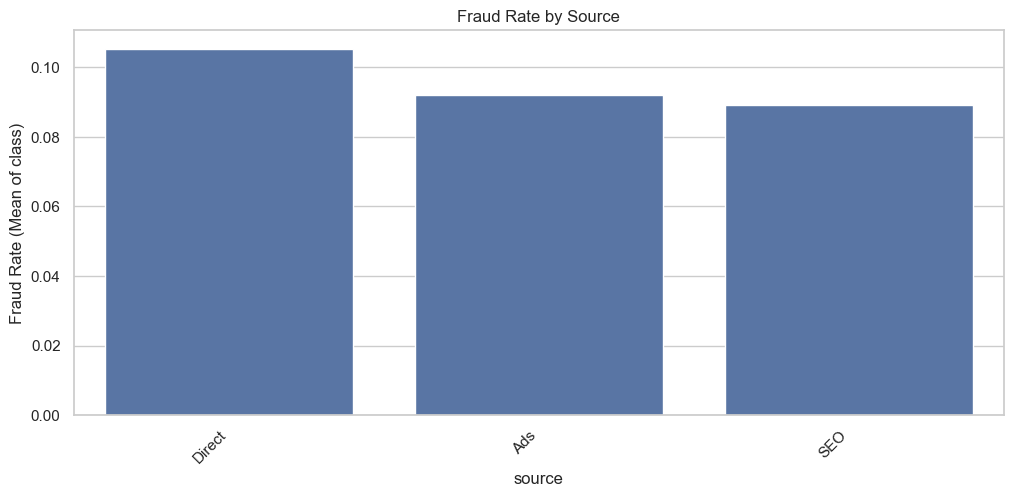

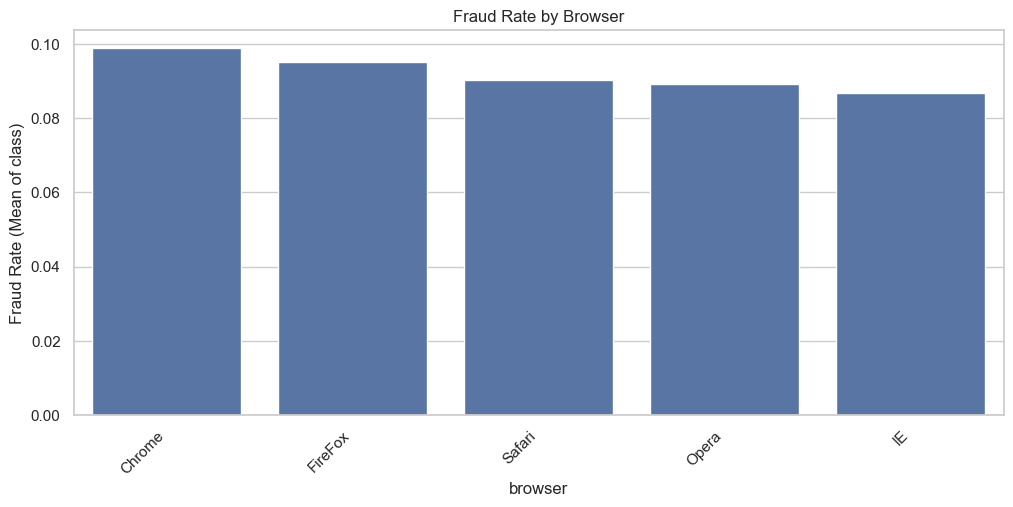

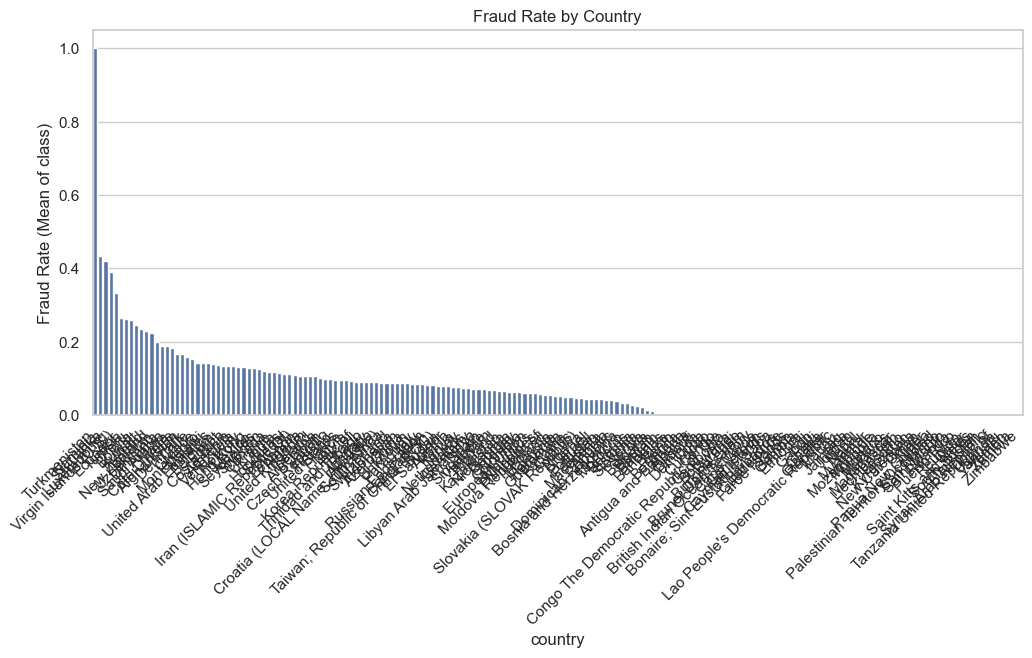

In [32]:
# Cell 17: Fraud rate by categorical features (bar plots with proportions)

categorical_vars = ['sex', 'source', 'browser', 'country']

for cat in categorical_vars:
    plt.figure(figsize=(12, 5))
    prop_df = fraud_df.groupby(cat)['class'].mean().sort_values(ascending=False)
    sns.barplot(x=prop_df.index, y=prop_df.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Fraud Rate (Mean of class)')
    plt.title(f'Fraud Rate by {cat.capitalize()}')
    plt.show()


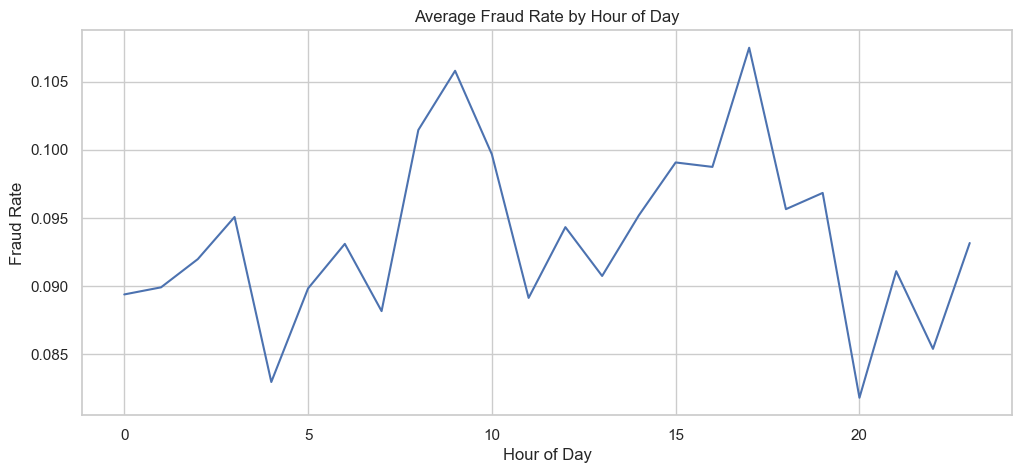

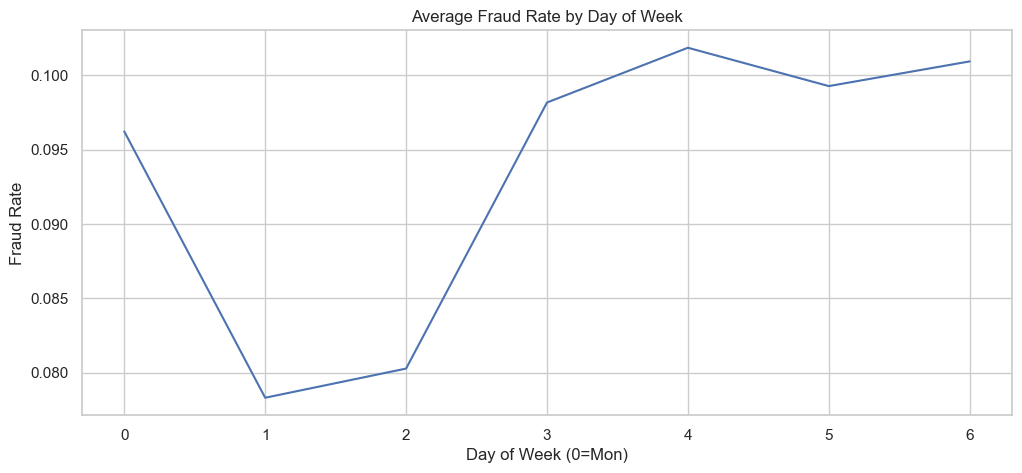

In [33]:
# Cell 18: Fraud distribution by hour of day and day of week

plt.figure(figsize=(12, 5))
sns.lineplot(x='hour_of_day', y='class', data=fraud_df.groupby('hour_of_day')['class'].mean().reset_index())
plt.title('Average Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(x='day_of_week', y='class', data=fraud_df.groupby('day_of_week')['class'].mean().reset_index())
plt.title('Average Fraud Rate by Day of Week')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Fraud Rate')
plt.show()


In [34]:
# Cell 19: Additional user-level aggregate features

# Total transactions per user
user_txn_counts = fraud_df.groupby('user_id')['purchase_value'].count().rename('total_transactions')

# Average purchase value per user
user_avg_purchase = fraud_df.groupby('user_id')['purchase_value'].mean().rename('avg_purchase_value')

# Number of unique devices used per user
user_device_counts = fraud_df.groupby('user_id')['device_id'].nunique().rename('unique_devices')

# Merge these features back to fraud_df
fraud_df = fraud_df.merge(user_txn_counts, on='user_id', how='left')
fraud_df = fraud_df.merge(user_avg_purchase, on='user_id', how='left')
fraud_df = fraud_df.merge(user_device_counts, on='user_id', how='left')

fraud_df[['user_id', 'total_transactions', 'avg_purchase_value', 'unique_devices']].head()


,user_id,total_transactions,avg_purchase_value,unique_devices
0,2,1,54.0,1
1,4,1,41.0,1
2,8,1,47.0,1
3,9,1,62.0,1
4,12,1,35.0,1


In [35]:
# Cell 20: Update features list to include new user aggregate features

features_extended = features + ['total_transactions', 'avg_purchase_value', 'unique_devices']

X = fraud_df[features_extended].copy()
y = fraud_df[target].copy()

# Fill missing time_since_prev_purchase
X.loc[:, 'time_since_prev_purchase'] = X['time_since_prev_purchase'].fillna(-1)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Features shape after encoding extended features:", X_encoded.shape)


Features shape after encoding extended features: (151112, 198)


In [36]:
# Cell 21: Text justification for choice of SMOTE

justification_text = """
The dataset shows significant class imbalance with the fraud class representing approximately 9.3% of all transactions.
To address this imbalance and help improve model learning for the minority class, SMOTE (Synthetic Minority Over-sampling Technique) was applied 
exclusively on the training data. SMOTE synthesizes new minority class examples, avoiding simple duplication which can cause overfitting.
Random undersampling was considered but was avoided to prevent loss of valuable data from the majority class.
This approach helps the model to learn more balanced decision boundaries and improve fraud detection performance.
"""

print(justification_text)



The dataset shows significant class imbalance with the fraud class representing approximately 9.3% of all transactions.
To address this imbalance and help improve model learning for the minority class, SMOTE (Synthetic Minority Over-sampling Technique) was applied 
exclusively on the training data. SMOTE synthesizes new minority class examples, avoiding simple duplication which can cause overfitting.
Random undersampling was considered but was avoided to prevent loss of valuable data from the majority class.
This approach helps the model to learn more balanced decision boundaries and improve fraud detection performance.

